# Coursera capstone final project
## Clustering Neighbourds of Greater Manschester

#  

### Importing required libraries

In [105]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import csv

import geocoder
import json

import matplotlib.pyplot as plt
%matplotlib inline

### Geeting Areas of Greater Manchester from wikipedia

In [22]:
source = requests.get('https://en.wikipedia.org/wiki/Category:Areas_of_Greater_Manchester').text
soup = BeautifulSoup(source, 'lxml')
dummy = soup.find_all(class_ = 'mw-category-group')

manchester = []
for i in range(len(dummy)):
    lists = dummy[i].find_all('a')
    for lis in lists:
        temp = lis.get('title')
        manchester.append(temp)
 
for i in range(len(manchester)):
    if i<=20:
        manchester.remove(manchester[i])
        
manchester.remove('Category:Areas of Bolton')
manchester.remove('Category:Areas of Manchester')
manchester.remove('Category:Areas of the Metropolitan Borough of Rochdale')
manchester.remove('Category:Areas of Stockport')

print(manchester)

['Agecroft', 'Ashton upon Mersey', "Besses o' th' Barn", 'Boothstown', 'Bradshaw, Greater Manchester', 'Brandlesholme', 'Bromley Cross', 'Carrbrook', 'Copley, Greater Manchester', 'Davyhulme', 'Fairfield, Tameside', 'Fishpool', 'Four Heatons', 'Gigg, Greater Manchester', 'Hart Common', 'Heyheads', 'Higher End', 'Hindsford', 'Houldsworth Model Village', 'Howe Bridge', 'Ladybrook Valley', 'Langley, Greater Manchester', 'Lees, Greater Manchester', 'Littlemoss', 'Longshaw', 'Makerfield', 'Matley', 'Middlebrook, Greater Manchester', 'Monton', 'Moses Gate', 'Mosley Common', 'Norbury, Greater Manchester', 'North Reddish', 'Old Trafford (area)', 'Orrell, Greater Manchester', 'Patricroft', 'Peel Green', 'Pennington, Greater Manchester', 'Pilsworth', 'Reddish', 'Redvales', 'Romiley', 'Rumworth', 'Rusholme', 'Salford Quays', 'Sedgley Park', 'Shakerley', 'South Reddish', 'South Turton', 'Tonge, Middleton', 'Torkington', 'Trafford Park', 'Unsworth', 'Urmston', 'Wallsuches', 'Walmersley', 'Warburton

### Conerting to Data Frame

In [84]:
df = pd.DataFrame()
df['Area of Manchester'] = manchester
df.head()

,Area of Manchester
0,Agecroft
1,Ashton upon Mersey
2,Besses o' th' Barn
3,Boothstown
4,"Bradshaw, Greater Manchester"


### Geeting latitude and longitude

In [86]:
from opencage.geocoder import OpenCageGeocode

key = 'ab247b6526314f699593f70221a57167'
geocoder = OpenCageGeocode(key)

end = ' , Greater Manchester'

lat = []
lon = []

for name in df['Area of Manchester']:
    query = str(name) + end
    result = geocoder.geocode(query)
    lat.append(result[0]['geometry']['lat'])
    lon.append(result[0]['geometry']['lng'])

In [87]:
df['Latitudes'] = lat
df['Longitudes'] = lon

df.rename(columns={'Area of Manchester' : 'Neighborhoods'} , inplace=True)
df.head()

,Neighborhoods,Latitudes,Longitudes
0,Agecroft,53.505212,-2.299912
1,Ashton upon Mersey,53.429835,-2.343177
2,Besses o' th' Barn,53.541943,-2.286099
3,Boothstown,53.500480,-2.431061
4,"Bradshaw, Greater Manchester",53.606603,-2.398959


### Dependencies of ploting

In [88]:
# Downloading folium, if not installed
!conda install -c conda-forge folium=0.5.0 --yes
import folium                             # Map plotting library
from pandas.io.json import json_normalize # Tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Import k-means from clustering stage
from sklearn.cluster import KMeans

print("Dependencies installed !")

Solving environment: ...working... 
  - anaconda/win-64::openssl-1.1.1d-he774522_2
  - defaults/win-64::openssl-1.1.1d-he774522_2done

# All requested packages already installed.

Dependencies installed !


In [90]:
gman_lat = 53.4576
gman_lng = -2.1578

# Creates map of Greater Manchester using latitude and longitude values
map_man = folium.Map(location=[gman_lat, gman_lng], zoom_start=10)

# Add markers to map
for lat, lng, neighborhood in zip(df['Latitudes'], df['Longitudes'], df['Neighborhoods']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_man)
    
map_man

### Defining own function to get the name of category

In [97]:
def get_category_type(row):
    
    categories_list = row['Category']  
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Using the FourSquare API

In [99]:
explore_df_list = []

for i, nbd_name in enumerate(df['Neighborhoods']):  
    try :
        # Getting the data of neighbourhood
        nbd_name = df.loc[i, 'Neighborhoods']
        nbd_lat = df.loc[i, 'Latitudes']
        nbd_lng = df.loc[i, 'Longitudes']

        radius = 1000 # Setting the radius as 1000 metres
        LIMIT = 30 # Getting the top 30 venues

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={} \
        &client_secret={}&ll={},{}&v={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, nbd_lat, nbd_lng, VERSION, radius, LIMIT)

        results = json.loads(requests.get(url).text)
        results = results['response']['groups'][0]['items']

        nearby = json_normalize(results) # Flattens JSON
        
         # Filtering the columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby = nearby.loc[:, filtered_columns]

        # Renaming the columns
        columns = ['Name', 'Category', 'Latitude', 'Longitude']
        nearby.columns = columns

        # Gets the categories
        nearby['Category'] = nearby.apply(get_category_type, axis=1)    

        # Gets the data required
        for i, name in enumerate(nearby['Name']):
            s_list = nearby.loc[i, :].values.tolist()  # Converts the numpy array to a python list
            f_list = [nbd_name, nbd_lat, nbd_lng] + s_list
            explore_df_list.append(f_list)

    except Exception as e:
        pass

In [100]:
explore_df = pd.DataFrame([item for item in explore_df_list])
explore_df.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Name', 'Venue Category', 'Venue Latitude', 'Venue Longitude']
explore_df

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
0,Agecroft,53.505212,-2.299912,Premier Inn Manchester (Swinton),Hotel,53.508184,-2.312279
1,Agecroft,53.505212,-2.299912,Aldi,Supermarket,53.500841,-2.309677
2,Agecroft,53.505212,-2.299912,JJ Food Service - Manchester,Food & Drink Shop,53.505718,-2.299797
3,Agecroft,53.505212,-2.299912,The Vine Cafe,Café,53.499610,-2.307099
4,Agecroft,53.505212,-2.299912,Tarmac Agecroft Asphalt2Go Asphalt Plant,Construction & Landscaping,53.503707,-2.294260
...,...,...,...,...,...,...,...
603,"Woodley, Greater Manchester",53.426686,-2.096080,Woodley Precinct,Plaza,53.427790,-2.099619
604,"Woodley, Greater Manchester",53.426686,-2.096080,Woodley Railway Station (WLY),Train Station,53.429402,-2.092790
605,"Woodley, Greater Manchester",53.426686,-2.096080,Bredbury Railway Station (BDY),Train Station,53.425420,-2.105551
606,"Woodley, Greater Manchester",53.426686,-2.096080,Tie Dry Ltd,Construction & Landscaping,53.425634,-2.084722


### Performing one-hot encoding

### Geeting top 10 venues

In [103]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


man_grouped = man_onehot.groupby('Neighbourhood').mean().reset_index()
man_grouped.head()


num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = man_grouped['Neighbourhood']

for ind in np.arange(man_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(man_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agecroft,Pizza Place,Café,Sandwich Place,Pet Store,Chinese Restaurant,Food & Drink Shop,Hotel,Supermarket,Grocery Store,Construction & Landscaping
1,Ashton upon Mersey,Grocery Store,Pub,Hotel,Convenience Store,Event Service,Film Studio,Fast Food Restaurant,Farm,Falafel Restaurant,Event Space
2,Besses o' th' Barn,Indian Restaurant,Coffee Shop,Bakery,Pharmacy,Soccer Stadium,Hotel,Latin American Restaurant,Pizza Place,Pub,Seafood Restaurant
3,Boothstown,Indian Restaurant,Pub,Flower Shop,Wine Bar,Food & Drink Shop,Doctor's Office,Dog Run,Electronics Store,English Restaurant,Event Service
4,"Bradshaw, Greater Manchester",Pub,Supermarket,Cosmetics Shop,Gastropub,Construction & Landscaping,Chinese Restaurant,Home Service,Event Service,Event Space,Flower Shop


In [104]:
man_grouped_clustering = man_grouped.drop('Neighbourhood', 1)

### K-means clustering

### silhouette_score for 2 to 10 clusters

In [137]:
from sklearn.metrics import silhouette_score

indices = []
scores = []

for kclusters in range(2, 11) :
    
    # Run k-means clustering
    kgc = man_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kgc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kgc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

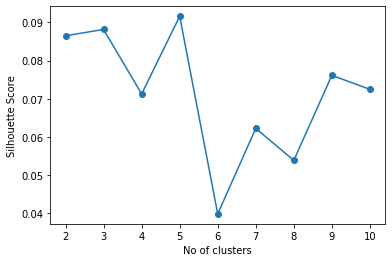

In [150]:
plt.plot(range(2,11), scores, 'o-')
plt.xlabel("No of clusters")
plt.ylabel("Silhouette Score")
plt.show()

### selecting 5 cluster

In [142]:
opt = 5

kgc = man_grouped_clustering
kmeans = KMeans(n_clusters = opt, init = 'k-means++', random_state = 0).fit(kgc)

In [144]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [151]:
man_merged = df
man_merged = man_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighborhoods')
man_merged.dropna(inplace = True)
man_merged['Cluster Labels'] = man_merged['Cluster Labels'].astype(int)
man_merged

,Neighborhoods,Latitudes,Longitudes,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agecroft,53.505212,-2.299912,4,Pizza Place,Café,Sandwich Place,Pet Store,Chinese Restaurant,Food & Drink Shop,Hotel,Supermarket,Grocery Store,Construction & Landscaping
1,Ashton upon Mersey,53.429835,-2.343177,1,Grocery Store,Pub,Hotel,Convenience Store,Event Service,Film Studio,Fast Food Restaurant,Farm,Falafel Restaurant,Event Space
2,Besses o' th' Barn,53.541943,-2.286099,4,Indian Restaurant,Coffee Shop,Bakery,Pharmacy,Soccer Stadium,Hotel,Latin American Restaurant,Pizza Place,Pub,Seafood Restaurant
3,Boothstown,53.500480,-2.431061,4,Indian Restaurant,Pub,Flower Shop,Wine Bar,Food & Drink Shop,Doctor's Office,Dog Run,Electronics Store,English Restaurant,Event Service
4,"Bradshaw, Greater Manchester",53.606603,-2.398959,1,Pub,Supermarket,Cosmetics Shop,Gastropub,Construction & Landscaping,Chinese Restaurant,Home Service,Event Service,Event Space,Flower Shop
5,Brandlesholme,53.607406,-2.312156,1,Pub,Grocery Store,Campground,Bus Stop,Park,Falafel Restaurant,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farm
6,Bromley Cross,53.617096,-2.414815,4,Sandwich Place,Train Station,Health & Beauty Service,Grocery Store,Hotel,Breakfast Spot,Wine Bar,Falafel Restaurant,Film Studio,Fast Food Restaurant
7,Carrbrook,53.505455,-2.020720,2,Golf Course,Home Service,Convenience Store,Park,Event Space,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farm,Falafel Restaurant
8,"Copley, Greater Manchester",53.486281,-2.041404,1,Gym Pool,Pool,Pub,Park,Flower Shop,Doctor's Office,Dog Run,Electronics Store,English Restaurant,Event Service
9,Davyhulme,53.454608,-2.367735,4,Pub,Gym,Bar,Park,Playground,Italian Restaurant,Indian Restaurant,Soccer Field,Train Station,Asian Restaurant


In [162]:
man_merged[man_merged['Cluster Labels'] == 0]

,Neighborhoods,Latitudes,Longitudes,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Higher End,53.512547,-2.150836,0,Supermarket,Tram Station,Furniture / Home Store,Fast Food Restaurant,Pub,Event Service,Film Studio,Farm,Falafel Restaurant,Event Space
17,Hindsford,53.518633,-2.478915,0,Supermarket,Fast Food Restaurant,Roller Rink,Pub,Soccer Field,Wine Bar,Event Space,Film Studio,Farm,Falafel Restaurant
38,Pilsworth,53.575140,-2.281866,0,Pub,Hotel,Supermarket,Wine Bar,Event Space,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farm,Falafel Restaurant
41,Romiley,53.414065,-2.096080,0,Supermarket,Pub,Train Station,Gym,Grocery Store,Gastropub,Fast Food Restaurant,Farm,Falafel Restaurant,Event Space
46,Shakerley,53.523139,-2.469112,0,Supermarket,Train Station,Fast Food Restaurant,Pub,Event Service,Fish & Chips Shop,Film Studio,Farm,Falafel Restaurant,Event Space
